In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
ROOT_DIR = '/home/gagliardi/rnsa'
sys.path.append(os.path.join(ROOT_DIR, 'SSD-Tensorflow'))  # To find local version of the library

In [17]:
import tensorflow as tf

import pandas as pd
import pydicom
from io import BytesIO
import glob, pylab, pandas as pd
import numpy as np

flags = tf.app.flags
FLAGS = flags.FLAGS
import os
from nets import ssd_vgg_300
from preprocessing.ssd_vgg_preprocessing import tf_summary_image, distorted_bounding_box_crop
import parse_tfrecord
from visualization import parse_data, draw, draw_image_and_bboxes, draw_bounding_box
debug = False

In [18]:
df = pd.read_csv('./data/stage_1_train_labels.csv')
parsed = parse_data(df)

### 0 - Preprocessing image

In [21]:
def preprocess_for_train_1(image, labels, bboxes,
                         out_shape, data_format='NHWC',
                         scope='ssd_preprocessing_train'):
    """Preprocesses the given image for training.

    Note that the actual resizing scale is sampled from
        [`resize_size_min`, `resize_size_max`].

    Args:
        image: A `Tensor` representing an image of arbitrary size.
        output_height: The height of the image after preprocessing.
        output_width: The width of the image after preprocessing.
        resize_side_min: The lower bound for the smallest side of the image for
            aspect-preserving resizing.
        resize_side_max: The upper bound for the smallest side of the image for
            aspect-preserving resizing.

    Returns:
        A preprocessed image.
    """
    fast_mode = False
    with tf.name_scope(scope, 'ssd_preprocessing_train', [image, labels, bboxes]):
        if image.get_shape().ndims != 3:
            raise ValueError('Input must be of size [height, width, C>0]')
        # Convert to float scaled [0, 1].
        if image.dtype != tf.float32:
            image = tf.image.convert_image_dtype(image, dtype=tf.float32)
        tf_summary_image(image, bboxes, 'image_with_bboxes')
        
        
        # Distort image and bounding boxes.
        MIN_OBJECT_COVERED = 0.25
        dst_image = image
        dst_image, labels, bboxes, distort_bbox = distorted_bounding_box_crop(image, 
                                                                              labels, 
                                                                              bboxes, 
                                                                              min_object_covered=MIN_OBJECT_COVERED)
        
        return dst_image, labels, bboxes, distort_bbox
        '''         
        # Resize image to output size.
        dst_image = tf_image.resize_image(dst_image, out_shape,
                                          method=tf.image.ResizeMethod.BILINEAR,
                                          align_corners=False)
        tf_summary_image(dst_image, bboxes, 'image_shape_distorted')

        # Randomly flip the image horizontally.
        dst_image, bboxes = tf_image.random_flip_left_right(dst_image, bboxes)

        # Randomly distort the colors. There are 4 ways to do it.
        dst_image = apply_with_random_selector(
                dst_image,
                lambda x, ordering: distort_color(x, ordering, fast_mode),
                num_cases=4)
        tf_summary_image(dst_image, bboxes, 'image_color_distorted')

        # Rescale to VGG input scale.
        image = dst_image * 255.
        image = tf_image_whitened(image, [_R_MEAN, _G_MEAN, _B_MEAN])
        # Image data format.
        if data_format == 'NCHW':
            image = tf.transpose(image, perm=(2, 0, 1))
        '''

### 1-Dataset iteration 

In [23]:
filenames = ["./data/tf_record_data/train-00000-of-00010"]
num_preprocessing_threads = 8

#image = tf.placeholder(tf.uint8, shape=(1024, 1024, 3))
#labels = tf.placeholder(tf.int64, shape=(1,))
#bboxes = tf.placeholder(tf.float32, shape=(None, 4))

ssd_net = ssd_vgg_300.SSDNet() 

ssd_shape = ssd_net.params.img_shape
ssd_anchors = ssd_net.anchors(ssd_shape)
    
# resizing pictures
out_shape = tf.constant([300, 300])
#out_shape = tf.placeholder(tf.int32, shape=(2,))
#Num_samples x Height x Width x Channels
DATA_FORMAT = 'NHWC'
#filenames = glob.glob('/home/gagliardi/rnsa/data/tf_record_data/*')
iterator = parse_tfrecord.get_iterator(filenames)
filename, image, labels, bboxes = iterator.get_next()

# Pre-processing image, labels and bboxes.
pimage, labels, pbboxes, distort_bbox = preprocess_for_train_1(image, labels, bboxes, out_shape, data_format=DATA_FORMAT)

image_with_box_0 = draw_bounding_box(image, bboxes)
image_with_box_1 = draw_bounding_box(pimage, pbboxes)

In [24]:
sess = tf.InteractiveSession()
sess.run(iterator.initializer)

In [29]:
filename_, image_with_box_0_, image_with_box_1_ = sess.run([filename, image_with_box_0, image_with_box_1])

### Original

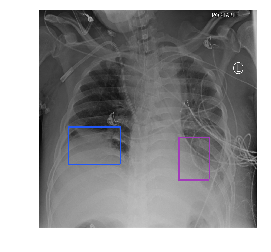

In [30]:
draw(parsed[filename_.decode('utf-8')])

### Draw out of iterator data

(-0.5, 1023.5, 1023.5, -0.5)

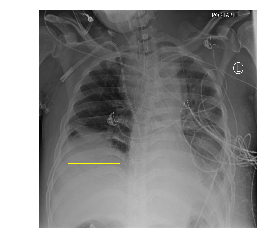

In [31]:
pylab.imshow(image_with_box_0_, cmap=pylab.cm.gist_gray)
pylab.axis('off')

### Draw convert to float32 boxes

(-0.5, 529.5, 582.5, -0.5)

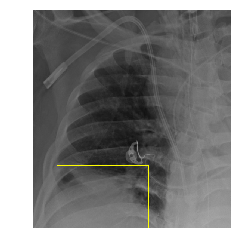

In [32]:
pylab.imshow(image_with_box_1_, cmap=pylab.cm.gist_gray)
pylab.axis('off')

- L'absence de bb est un probleme d'affichage basique
- Cependant le cropping est etrange, il n'inclut pas la totalite de la bounding box: apparement c'est normal

- what is segmentation compare to object detection?
- Should I use a less complexe neural net ?

